## ECE 498 DS - Mini-Project 2:  MiMoSA 
##### MiMoSA (Mixture Model-based Single-cell Analysis) is a workflow to cluster single-cells using RPKM measure output by the MapRSeq pipeline developed at Mayo Clinic.

### Originally developed by Arjun Athreya (athreya2@illinois.edu) in R 
### Research Paper available at http://ieeexplore.ieee.org/abstract/document/7822581/

#### ECE 498 DS Staff (Saurabh Jha and Lavin Devnani adapted the code for Python and Jupyter Notebook)


# Import Packages for Working With the Datasets
* pandas - to load datasets
* numpy - vector manipulation
* matplotlib - plotting/visualization
* sklean - scikit learning package containg ML algorithm implementations
* seaborn - plotthing/visualization

In [14]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from scipy import stats

import seaborn as sns
# %matplotlib notebook
sns.set_style('whitegrid')
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Biology Primer

## What is a gene?
A gene is a sequence of DNA or RNA which codes for a molecule that has a function.

https://en.wikipedia.org/wiki/Gene

https://www.youtube.com/watch?v=ONGdehkB8jU

## What is a cell?
The cell  is the basic structural, functional, and biological unit of all known living organisms. A cell is the smallest unit of life that can replicate independently, and cells are often called the "building blocks of life". 

https://en.wikipedia.org/wiki/Cell_(biology)

## What is a gene expression?
Gene expression is the activity level of a gene.

https://en.wikipedia.org/wiki/Gene_expression

## What is RPKM?
**RPKM** is reads per kilobase per million mapped reads, which is how many reads (short sequences from a sequencing machine) map to a region of a gene. So at large without loosing generality, better the RPKM better the quality of the gene expression data. 

### You may skip the details about RPKM below
The expression value for each gene was normalized by accounting for the sequencing depth (number of short DNA sequence strings from the sequencing platform aligned to a gene) and length of the gene. The measure of gene expression is Reads Per Kilo Million (RPKM). The range of the RPKM is between 0 and 2, 000.

**Formula**

RPKM =   numReads / ( geneLength/1000 * totalNumReads/1,000,000 )

numReads - number of reads mapped to a gene sequence

geneLength - length of the gene sequence

totalNumReads - total number of mapped reads of a sample


# Import your dataset into the pandas dataframe
### Recall that our experiment consists of two different datasets
   1. Baseline: Cells are not treated with metformin
   2. Metformin: Cells are treated with metformin
   

In [15]:
baseline_csv = pd.read_csv("498DS_BaselineData.csv")
metformin_csv = pd.read_csv("498DS_MetforminData.csv")

# Exploring Pandas Dataframe
## You would want to run the following commands associated with pandas to explore the pandas dataframes
 1. head - helps to visualize first few rows and first few columns, e.g. usage 
   ```python 
   baseline_csv.head()
   ```
 2. len - returns number of rows or columns in the dataset based on the usage, e.g. usage
   ```python
   # return number of rows
   len(baseline_csv)
   # returns number of columns
   len(baseline_csv.columns)
   ```
 3. list - returns list of all columns, e.g. usage
    ```python 
    list(baselines_csv)
    ```
 4. columns - returns columns of the dataframe. This command does not print all columns depending on notebook settings., e.g. usage
    ```python
    baseline_csv.columns
    ```

In [16]:
baseline_csv.head()

,Chr,GeneID,StartCoding,Stop,CodingLength,s_62_M2_N701_S502_RPKM,s_62_M2_N701_S503_RPKM,s_62_M2_N701_S504_RPKM,s_62_M2_N701_S505_RPKM,s_62_M2_N701_S506_RPKM,...,s_85_M2_N711_S501_RPKM,s_85_M2_N711_S502_RPKM,s_85_M2_N711_S503_RPKM,s_85_M2_N711_S504_RPKM,s_85_M2_N711_S506_RPKM,s_85_M2_N711_S507_RPKM,s_85_M2_N711_S508_RPKM,s_85_M2_N712_S503_RPKM,s_85_M2_N712_S504_RPKM,s_85_M2_N712_S505_RPKM
0,chr1,AKR1A1,46016455,46035723,1580,0.000000,0.000000,14.531662,14.268424,26.459120,...,0.000000,0.0,1.037722,24.391142,17.188837,0.000000,2.173159,48.894683,9.213393,0.000000
1,chr1,ANP32E,150190717,150208504,3553,263.583489,0.000000,871.851991,439.864123,575.552858,...,526.275026,0.0,454.455263,587.120601,469.683190,565.316349,343.552412,236.214451,838.993154,141.792692
2,chr1,ARF1,228270361,228286913,2198,41.926167,486.847569,110.116896,156.263029,51.559562,...,148.414035,0.0,36.850006,106.643195,78.107210,40.569316,104.663612,92.728846,80.468384,32.867866
3,chr1,ARPC5,183595332,183604985,1982,63.349868,0.000000,139.493933,170.281826,184.750299,...,30.830665,0.0,184.144951,65.880840,60.437829,70.357630,150.501134,94.707269,144.506633,58.816776
4,chr1,ATP5F1,111991743,112004525,2101,327.593082,0.000000,221.522538,311.490830,207.609025,...,221.936539,0.0,175.275819,141.346657,177.968802,189.485482,113.785720,198.088156,76.215503,37.511264


In [17]:
metformin_csv.head()

,Chr,GeneID,Start,Stop,CodingLength,s_63_M2_N701_S501_RPKM,s_63_M2_N701_S502_RPKM,s_63_M2_N701_S503_RPKM,s_63_M2_N701_S504_RPKM,s_63_M2_N701_S505_RPKM,...,s_204_M2_N712_S501_RPKM,s_204_M2_N712_S502_RPKM,s_204_M2_N712_S503_RPKM,s_204_M2_N712_S504_RPKM,s_204_M2_N712_S505_RPKM,s_204_M2_N712_S506_RPKM,s_204_M2_N712_S507_RPKM,s_204_M2_N712_S508_RPKM,s_lane1_Undetermined_RPKM.1,s_lane2_Undetermined_RPKM.1
0,chr1,ANKRD36BP1,168214819,168216668,1850,0.440043,0.000000,12.693285,27.412660,7.378925,...,0.141431,4.867474,0.000000,2.293990,0.000000,2.508867,1.699676,10.164217,6.560453,4.703404
1,chr1,ANP32E,150190717,150208504,3553,517.592029,10.749289,754.147392,534.208422,356.355539,...,1533.653888,586.403579,571.360726,1441.236773,793.018158,439.711955,504.272351,634.004705,622.270556,633.534112
2,chr1,APOA1BP,156561558,156564091,1121,79.882864,0.608389,1.102520,5.517006,6.088765,...,44.580451,65.266924,0.000000,9.043854,13.633060,0.414041,38.147951,96.536841,47.216858,48.830575
3,chr1,ARF1,228270361,228286913,2198,231.482884,70.434447,73.379540,139.279295,166.755975,...,319.976644,99.860175,0.000000,86.242051,50.008005,134.934356,19.741917,156.957326,148.013958,152.447260
4,chr1,ARPC5,183595332,183604985,1982,162.240771,59.185012,164.311943,123.878491,244.505991,...,205.146479,135.163275,0.000000,135.491107,155.697364,77.512851,121.841571,151.602966,132.166204,136.973007


In [18]:
print("Number of rows %d" % len(baseline_csv))
print("Number of columns %d" % len(baseline_csv.columns))

Number of rows 1170
Number of columns 174


In [19]:
list(baseline_csv)

['Chr',
 'GeneID',
 'StartCoding',
 'Stop',
 'CodingLength',
 's_62_M2_N701_S502_RPKM',
 's_62_M2_N701_S503_RPKM',
 's_62_M2_N701_S504_RPKM',
 's_62_M2_N701_S505_RPKM',
 's_62_M2_N701_S506_RPKM',
 's_62_M2_N701_S507_RPKM',
 's_62_M2_N701_S508_RPKM',
 's_62_M2_N702_S501_RPKM',
 's_62_M2_N702_S502_RPKM',
 's_62_M2_N702_S503_RPKM',
 's_62_M2_N702_S504_RPKM',
 's_62_M2_N702_S505_RPKM',
 's_62_M2_N702_S506_RPKM',
 's_62_M2_N702_S507_RPKM',
 's_62_M2_N702_S508_RPKM',
 's_62_M2_N703_S501_RPKM',
 's_62_M2_N703_S502_RPKM',
 's_62_M2_N703_S504_RPKM',
 's_62_M2_N703_S505_RPKM',
 's_62_M2_N703_S506_RPKM',
 's_62_M2_N703_S507_RPKM',
 's_62_M2_N703_S508_RPKM',
 's_62_M2_N704_S501_RPKM',
 's_62_M2_N704_S502_RPKM',
 's_62_M2_N704_S503_RPKM',
 's_62_M2_N704_S504_RPKM',
 's_62_M2_N704_S505_RPKM',
 's_62_M2_N704_S506_RPKM',
 's_62_M2_N704_S507_RPKM',
 's_62_M2_N704_S508_RPKM',
 's_62_M2_N705_S501_RPKM',
 's_62_M2_N705_S502_RPKM',
 's_62_M2_N705_S504_RPKM',
 's_62_M2_N705_S505_RPKM',
 's_62_M2_N705_S506_R

In [20]:
list(metformin_csv)

['Chr',
 'GeneID',
 'Start',
 'Stop',
 'CodingLength',
 's_63_M2_N701_S501_RPKM',
 's_63_M2_N701_S502_RPKM',
 's_63_M2_N701_S503_RPKM',
 's_63_M2_N701_S504_RPKM',
 's_63_M2_N701_S505_RPKM',
 's_63_M2_N701_S507_RPKM',
 's_63_M2_N701_S508_RPKM',
 's_63_M2_N702_S501_RPKM',
 's_63_M2_N702_S502_RPKM',
 's_63_M2_N702_S504_RPKM',
 's_63_M2_N702_S505_RPKM',
 's_63_M2_N702_S506_RPKM',
 's_63_M2_N702_S507_RPKM',
 's_63_M2_N702_S508_RPKM',
 's_63_M2_N703_S502_RPKM',
 's_63_M2_N703_S504_RPKM',
 's_63_M2_N703_S505_RPKM',
 's_63_M2_N703_S506_RPKM',
 's_63_M2_N703_S507_RPKM',
 's_63_M2_N703_S508_RPKM',
 's_63_M2_N704_S501_RPKM',
 's_63_M2_N704_S502_RPKM',
 's_63_M2_N704_S504_RPKM',
 's_63_M2_N704_S505_RPKM',
 's_63_M2_N704_S506_RPKM',
 's_63_M2_N704_S507_RPKM',
 's_63_M2_N704_S508_RPKM',
 's_63_M2_N705_S502_RPKM',
 's_63_M2_N705_S504_RPKM',
 's_63_M2_N705_S505_RPKM',
 's_63_M2_N705_S506_RPKM',
 's_63_M2_N705_S507_RPKM',
 's_63_M2_N705_S508_RPKM',
 's_63_M2_N706_S501_RPKM',
 's_63_M2_N706_S502_RPKM',


In [21]:
baseline_csv.columns

Index(['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength',
       's_62_M2_N701_S502_RPKM', 's_62_M2_N701_S503_RPKM',
       's_62_M2_N701_S504_RPKM', 's_62_M2_N701_S505_RPKM',
       's_62_M2_N701_S506_RPKM',
       ...
       's_85_M2_N711_S501_RPKM', 's_85_M2_N711_S502_RPKM',
       's_85_M2_N711_S503_RPKM', 's_85_M2_N711_S504_RPKM',
       's_85_M2_N711_S506_RPKM', 's_85_M2_N711_S507_RPKM',
       's_85_M2_N711_S508_RPKM', 's_85_M2_N712_S503_RPKM',
       's_85_M2_N712_S504_RPKM', 's_85_M2_N712_S505_RPKM'],
      dtype='object', length=174)

In [22]:
baseline_csv['GeneID'].tolist()

['AKR1A1',
 'ANP32E',
 'ARF1',
 'ARPC5',
 'ATP5F1',
 'ATP6V0B',
 'ATPIF1',
 'C1orf122',
 'C1orf123',
 'C1orf133',
 'C1orf159',
 'C1orf31',
 'C1orf35',
 'C4BPB',
 'CACYBP',
 'CAPZA1',
 'CCT3',
 'CDC20',
 'CDC42',
 'CDCA8',
 'CKS1B',
 'CNIH4',
 'CNN3',
 'CTPS',
 'CYR61',
 'DDAH1',
 'DDOST',
 'DNAJC8',
 'DNTTIP2',
 'EFHD2',
 'EIF3I',
 'ENO1',
 'F3',
 'FBXO6',
 'G0S2',
 'GAS5',
 'GNG5',
 'GNPAT',
 'HBXIP',
 'HMGN2',
 'HNRNPR',
 'HSPB11',
 'ILF2',
 'ISG15',
 'JTB',
 'KDM1A',
 'KIF2C',
 'KRTCAP2',
 'LSM10',
 'MFSD2A',
 'MGST3',
 'MINOS1',
 'MRPL37',
 'MRPL55',
 'MRPS15',
 'MRPS21',
 'NDUFS5',
 'NME7',
 'NOC2L',
 'PARK7',
 'PFDN2',
 'PPOX',
 'PRDX1',
 'PRDX6',
 'PSMB4',
 'PSMD4',
 'RASAL2',
 'RHOC',
 'RPA2',
 'RPF1',
 'RPL11',
 'RPL5',
 'RPS27',
 'RPS8',
 'S100A10',
 'S100A11',
 'S100A16',
 'S100A4',
 'S100A6',
 'SCAMP3',
 'SDHB',
 'SEC22B',
 'SEP15',
 'SF3A3',
 'SH3BGRL3',
 'SLC39A1',
 'SLC50A1',
 'SNHG3',
 'SNORA61',
 'SNORD47',
 'SNORD80',
 'SNORD99',
 'SNRPE',
 'SRP9',
 'SSR2',
 'STMN1',


In [23]:
overlap = []
metformin_csv['GeneID'].tolist()
for x in baseline_csv['GeneID'].tolist():
    if x in metformin_csv['GeneID'].tolist():
        overlap.append(x)

print("There are", len(overlap), "overlapping genes")

There are 833 overlapping genes


# Notes
1. There are only 1170 rows and 174 columns
2. Not all columns are important for data analysis/clustering. E.g., Chr, GeneID, StartCoding, Stop, CodingLength are description about the feature and has relevance to biology
3. These datasets are already downsized from 23,398 genes to 1170 genes and 192 cells to 169 cells. Only 20% of the 23, 398 genes show expression levels greater than 32 on the RPKM scale, which is a heuristic that can be used to decide whether a gene is expressed or not as recommended by MAP-Rseq[1]. Roughly 10% of the baseline and metformin-treated cells had low sequencing coverage (< 1M reads per cell), so we excluded those cells from our analysis.

#### References
1. K. R. Kalari, A. A. Nair, J. D. Bhavsar, D. R. OBrien, J. I. Davila, M. A. Bockol, J. Nie, X. Tang, S. Baheti, J. B. Doughty et al., “Map- rseq: mayo analysis pipeline for rna sequencing,” BMC bioinformat- ics, vol. 15, no. 1, p. 1, 2014

# Visualizing datasets
## Plot 1 - Variation of gene expression across different genes for selected cells

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


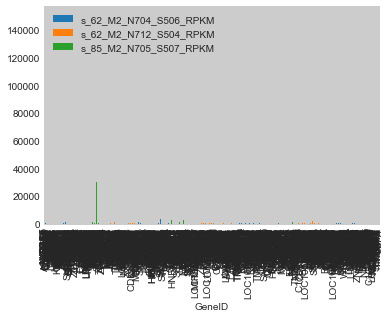

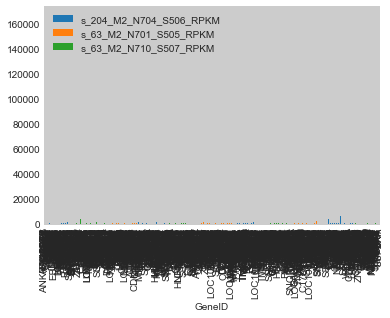

In [24]:
#'Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength', 
#'Chr', 'GeneID', 'Start', 'Stop', 'CodingLength', 
base1 = baseline_csv[['Chr', 'GeneID', 's_62_M2_N704_S506_RPKM','s_62_M2_N712_S504_RPKM', 's_85_M2_N705_S507_RPKM']]
met1 = metformin_csv[['Chr', 'GeneID','s_204_M2_N704_S506_RPKM', 's_63_M2_N701_S505_RPKM', 's_63_M2_N710_S507_RPKM']]
base1.plot(x='GeneID', y=['s_62_M2_N704_S506_RPKM','s_62_M2_N712_S504_RPKM', 's_85_M2_N705_S507_RPKM'], kind='bar')
met1.plot(x='GeneID', y=['s_204_M2_N704_S506_RPKM', 's_63_M2_N701_S505_RPKM', 's_63_M2_N710_S507_RPKM'], kind='bar')
plt.show()


## Plot 2 - Variation of gene expression across the cells for a given gene **ARPC5** or **CDC42**

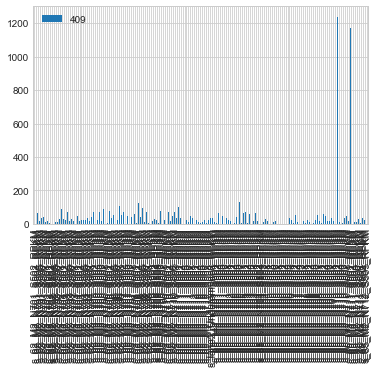

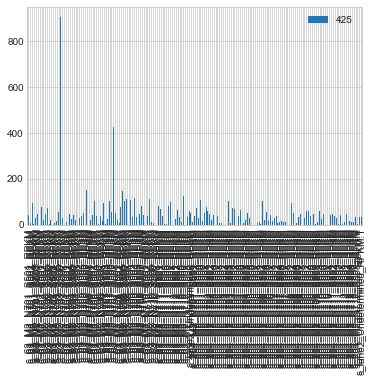

In [25]:
base = baseline_csv[baseline_csv['GeneID'] == 'SERPINB1']
met = metformin_csv[metformin_csv['GeneID'] == 'SERPINB1']

base2 = base.drop(columns=['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength'])
met2 = met.drop(columns=['Chr', 'GeneID', 'Start', 'Stop', 'CodingLength'])

base2 = base2.transpose()
met2 = met2.transpose()

base2.plot(kind = 'bar')
met2.plot(kind = 'bar')
plt.show()

# Comparing the distributions

In [26]:
baselineT = baseline_csv.transpose()
metforminT = metformin_csv.transpose()
geneNames = set(baseline_csv['GeneID'].tolist()).intersection(set(metformin_csv['GeneID'].tolist()))
print("%d genes common in both dataset" % len(geneNames))
numDifferentlyExpressedGene = 0
candidateGenes = set()
count10 = 0
count05 = 0
count025 = 0
count01 = 0
count005 = 0
count001 = 0
for selectGene in geneNames:
    bIndx = baselineT[1:2:].transpose()['GeneID'].tolist().index(selectGene)
    mIndx = metforminT[1:2:].transpose()['GeneID'].tolist().index(selectGene)
    b = np.log(baselineT[bIndx].iloc[6:169].astype(float))
    m = np.log(metforminT[mIndx].iloc[6:169].astype(float))
    Vars = {
        "Baseline": b,
        "Metformin": m
    }
    testResult = stats.ks_2samp(Vars['Baseline'], Vars["Metformin"])
    if testResult[1] < .1:
        count10+=1
        if testResult[1] < .05:
            count05+=1
            if testResult[1] < .025:
                count025+=1
                if testResult[1] < .01:
                    count01+=1
                    if testResult[1] < .005:
                        count005+=1
                        if testResult[1] < .001:
                            count001+=1
    if testResult[1] < 1e-1:
        candidateGenes.add(selectGene)
        numDifferentlyExpressedGene += 1
        print("%d: %s gene is differently expressed in baseline and metformin treated cells" % (numDifferentlyExpressedGene, selectGene))
        print("Test Statistics %f, %g" % (testResult[0], testResult[1]))

833 genes common in both dataset
1: MTRNR2L2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.619632, 2.08884e-28
2: MIR100HG gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.343558, 5.00091e-09
3: ALG8 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
4: ARF1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
5: PSMA1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.184049, 0.0067975
6: SNHG9 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.288344, 1.74498e-06
7: ATOX1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.208589, 0.00134942
8: ANXA2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.184049, 0.0067975
9: COPB1 gene is differently express

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log



48: RPSA gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
49: TXNRD1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.220859, 0.000557352
50: C20orf30 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.214724, 0.000872732
51: SLC35F2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
52: CINP gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
53: RPS19 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
54: PTMA gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
55: PSME2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.171779, 0.0141428
56: ADA gene is differently expressed in baseline and metformin 

125: P4HB gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.159509, 0.0279753
126: CISD2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
127: AP1S2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
128: THRAP3 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
129: SNHG1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.159509, 0.0279753
130: RPLP0 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
131: EIF5A gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
132: DANCR gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
133: RPL5 gene is differently expressed in baseline and metformin 

203: SERPINE1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.294479, 9.57651e-07
204: RPL39 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
205: TNFRSF12A gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
206: RPS25 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
207: PYCARD gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.171779, 0.0141428
208: IFITM3 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.202454, 0.00206028
209: RPL26 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
210: UBB gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
211: RPL24 gene is differently expressed in baseline an

292: RPS4X gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.239264, 0.000134573
293: SAP18 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.171779, 0.0141428
294: PSMC4 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
295: AXL gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.319018, 7.65624e-08
296: RPL18A gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.177914, 0.00986699
297: ARPC2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
298: RPL35A gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.190184, 0.0046241
299: RPL6 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.239264, 0.000134573
300: RRM2 gene is differently expressed in baseline and me

In [27]:
d = {'Alpha': [.1, .05, .025, .01, .005, .001], 'Different Genes Count': [count10, count05, count025, count01, count005, count001]}
df = pd.DataFrame(data=d)
df.head()

,Alpha,Different Genes Count
0,0.100,309
1,0.050,222
2,0.025,173
3,0.010,138
4,0.005,109


In [47]:
#Task2
rpkmThreshold = 32
numBaselineClustGMM = 2
numMetforminClustGMM = 3

baseRPKM = baseline_csv.drop(columns=['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength'])
metRPKM = metformin_csv.drop(columns=['Chr', 'GeneID', 'Start', 'Stop', 'CodingLength'])
baseRPKM = baseRPKM.transpose()
metRPKM = metRPKM.transpose()

baseGMM = GaussianMixture(n_components=numBaselineClustGMM, random_state=0).fit(baseRPKM)
baseGMM_pred = baseGMM.predict(baseRPKM)
baseCenters = baseGMM.means_
print(np.bincount(baseGMM_pred))
print(baseGMM_pred)
metGMM = GaussianMixture(n_components=numMetforminClustGMM, random_state=0).fit(metRPKM)
metGMM_pred = metGMM.predict(metRPKM)
metCenters = metGMM.means_
print(np.bincount(metGMM_pred))
print(len(metCenters))

print("Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene")
print("There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine")
print("There are 161 Cells in Cluster 0, 11 Cells in Cluster 1, and 5 Cells in Cluster 2 for Metformin")

[152  17]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[161  11   5]
3
Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene
There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine
There are 161 Cells in Cluster 0, 11 Cells in Cluster 1, and 5 Cells in Cluster 2 for Metformin


In [48]:
baseline_means = baseline_csv.iloc[:, 0:5]
baseline_means["1"] = baseCenters[0]
baseline_means["2"] = baseCenters[1]

metformin_means = metformin_csv.iloc[:, 0:5]
metformin_means["1"] = metCenters[0]
metformin_means["2"] = metCenters[1]
metformin_means["3"] = metCenters[2]
metformin_means.head()


,Chr,GeneID,Start,Stop,CodingLength,1,2,3
0,chr1,ANKRD36BP1,168214819,168216668,1850,6.961783,0.000000,209.918657
1,chr1,ANP32E,150190717,150208504,3553,589.414935,335.422835,369.797641
2,chr1,APOA1BP,156561558,156564091,1121,34.144335,78.297295,0.000000
3,chr1,ARF1,228270361,228286913,2198,129.281934,128.121970,191.948024
4,chr1,ARPC5,183595332,183604985,1982,132.848917,191.115200,0.000000


In [30]:
print(np.unique(baseGMM_pred, return_counts=True))
print(np.unique(metGMM_pred, return_counts=True))

print("Bu should be cluster 2 because it has 17 cells in it")
print("Bv should be cluster 1 because it has 152 cells in it")

print("Mx should be cluster 3 because it has 5 cells in it")
print("My should be cluster 2 because it has 11 cells in it")
print("Mz should be cluster 1 because it has 161 cells in it")

metformin_upMy_downMx_upMz_DF = metformin_means
metformin_upMy_downMx_upMz_DF = metformin_upMy_downMx_upMz_DF[metformin_upMy_downMx_upMz_DF['3'] < rpkmThreshold]
metformin_upMy_downMx_upMz_DF = metformin_upMy_downMx_upMz_DF[metformin_upMy_downMx_upMz_DF['2'] > rpkmThreshold]
metformin_upMy_downMx_upMz_DF = metformin_upMy_downMx_upMz_DF[metformin_upMy_downMx_upMz_DF['1'] > rpkmThreshold]

baseline_upBv_downBu_DF = baseline_means
baseline_upBv_downBu_DF = baseline_upBv_downBu_DF[baseline_upBv_downBu_DF['2'] < rpkmThreshold]
baseline_upBv_downBu_DF = baseline_upBv_downBu_DF[baseline_upBv_downBu_DF['1'] > rpkmThreshold]


(array([0, 1]), array([152,  17]))
(array([0, 1, 2]), array([161,  11,   5]))
Bu should be cluster 2 because it has 17 cells in it
Bv should be cluster 1 because it has 152 cells in it
Mx should be cluster 3 because it has 5 cells in it
My should be cluster 2 because it has 11 cells in it
Mz should be cluster 1 because it has 161 cells in it


In [52]:
geneList = metformin_upMy_downMx_upMz_DF['GeneID'].tolist()
newlyDownregulatedGenes_inMx_fromBu_df = metformin_upMy_downMx_upMz_DF
for x in baseline_upBv_downBu_DF['GeneID']:
    if x in geneList:
        newlyDownregulatedGenes_inMx_fromBu_df = newlyDownregulatedGenes_inMx_fromBu_df[newlyDownregulatedGenes_inMx_fromBu_df['GeneID'] != x]

geneList = newlyDownregulatedGenes_inMx_fromBu_df['GeneID'].tolist()
print(len(geneList))
for x in baseline_means['GeneID']:
    if x not in geneList:
        print(x)
        baseline_means = baseline_means[baseline_means['GeneID'] != x]
        metformin_means = metformin_means[metformin_means['GeneID'] != x]

geneList = baseline_means['GeneID'].tolist()
for x in metformin_means['GeneID'].tolist():
    if x not in geneList:
        metformin_means = metformin_means[metformin_means['GeneID'] != x]
        
baseline_means = baseline_means.reset_index(drop=True)
metformin_means = metformin_means.reset_index(drop=True)
print(len(baseline_means['GeneID'].tolist()))
dat = {'Bu': baseline_means['2'], 'Bv': baseline_means['1'], 'My': metformin_means['2'], 'Mz': metformin_means['1']}
new_df = pd.DataFrame(data=dat)
new_df = np.log(new_df + 1)

new_df['Mean'] = new_df.apply(np.mean, axis=1)
new_df['STD'] = new_df.apply(np.std, axis=1)
new_df['Mx'] = metformin_means['3']
new_df['Mx'] = np.log(new_df['Mx'] + 1)
new_df['GeneID'] = baseline_means['GeneID']
new_df = new_df[['GeneID', 'Bu', 'Bv', 'My', 'Mz', 'Mx', 'Mean', 'STD']]
new_df.head()

303
221


,GeneID,Bu,Bv,My,Mz,Mx,Mean,STD
0,ARPC5,3.966428,4.675347,5.258095,4.896712,0.0,4.699145,0.421639
1,ATP5F1,4.277536,5.373421,3.963450,5.336792,0.0,4.737800,0.561118
2,ATP6V0B,5.294395,5.100574,3.604205,4.868313,0.0,4.716872,0.590207
3,C1orf31,3.910229,4.499485,4.939882,4.543935,0.0,4.473383,0.328762
4,CDC20,5.081032,4.551463,6.026550,4.457334,0.0,5.029095,0.557253


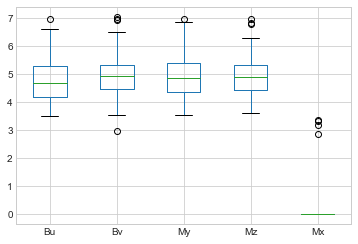

In [32]:
new_df.boxplot(column=['Bu', 'Bv', 'My', 'Mz', 'Mx'])
plt.show()

In [53]:
#K-means Clustering
rpkmThreshold = 32
numBaselineClustGMM = 2
numMetforminClustGMM = 3

baseKRPKM = baseline_csv.drop(columns=['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength'])
metKRPKM = metformin_csv.drop(columns=['Chr', 'GeneID', 'Start', 'Stop', 'CodingLength'])
baseKRPKM = baseKRPKM.transpose()
metKRPKM = metKRPKM.transpose()

def do_kmeans(matrix, num_clusters):
    cluster = KMeans(n_clusters=num_clusters, random_state=0).fit(matrix)
    kmeans_pred = cluster.predict(matrix)
    return silhouette_score(matrix, kmeans_pred)

print("Silhouette Analysis for BaseRPKM\n")
N = [i for i in range (2, len(baseKRPKM))]
scores = [do_kmeans(baseKRPKM, i) for i in N]
recommended_BaselineN = scores.index(max(scores)) + 2
for i in range(0, len(N)):
    print("For n={}, score={:.3f}".format(N[i], scores[i]))
    

print("Silhouette Analysis for MetRPKM\n")
N = [i for i in range (2, len(metKRPKM))]
scores = [do_kmeans(metKRPKM, i) for i in N]
recommended_MetforminN = scores.index(max(scores)) + 2
for i in range(0, len(N)):
    print("For n={}, score={:.3f}".format(N[i], scores[i]))

Silhouette Analysis for BaseRPKM

For n=2, score=0.919
For n=3, score=0.879
For n=4, score=0.873
For n=5, score=0.839
For n=6, score=0.840
For n=7, score=0.827
For n=8, score=0.829
For n=9, score=0.225
For n=10, score=0.841
For n=11, score=0.825
For n=12, score=0.235
For n=13, score=0.199
For n=14, score=0.210
For n=15, score=0.202
For n=16, score=0.200
For n=17, score=0.201
For n=18, score=0.210
For n=19, score=0.209
For n=20, score=0.199
For n=21, score=0.201
For n=22, score=0.193
For n=23, score=0.178
For n=24, score=0.166
For n=25, score=0.108
For n=26, score=0.095
For n=27, score=0.075
For n=28, score=0.073
For n=29, score=0.069
For n=30, score=0.078
For n=31, score=0.100
For n=32, score=0.070
For n=33, score=0.080
For n=34, score=0.074
For n=35, score=0.081
For n=36, score=0.079
For n=37, score=0.076
For n=38, score=0.071
For n=39, score=0.072
For n=40, score=0.061
For n=41, score=0.071
For n=42, score=0.078
For n=43, score=0.064
For n=44, score=0.052
For n=45, score=0.064
For n=

In [59]:
baseKM = KMeans(n_clusters=2, random_state=0).fit(baseKRPKM)
baseKM_pred = baseKM.predict(baseKRPKM)
baseKCenters = baseKM.cluster_centers_
print(len(baseKM_pred))
print(np.bincount(baseKM_pred))
metKM = KMeans(n_clusters=2, random_state=0).fit(metKRPKM)
metKM_pred = metKM.predict(metKRPKM)
metKCenters = metKM.cluster_centers_
print(np.bincount(metKM_pred))
#print(metKCenters)
print("Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene")
print("There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine")
print("There are 161 Cells in Cluster 0 and 16 Cells in Cluster 1 for Metformin")

169
[152  17]
[161  16]
Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene
There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine
There are 161 Cells in Cluster 0 and 16 Cells in Cluster 1 for Metformin


In [60]:
baseline_Kmeans = baseline_csv.iloc[:, 0:5]
baseline_Kmeans["1"] = baseKCenters[0]
baseline_Kmeans["2"] = baseKCenters[1]

metformin_Kmeans = metformin_csv.iloc[:, 0:5]
metformin_Kmeans["1"] = metKCenters[0]
metformin_Kmeans["2"] = metKCenters[1]
metformin_Kmeans.head()

,Chr,GeneID,Start,Stop,CodingLength,1,2
0,chr1,ANKRD36BP1,168214819,168216668,1850,6.961783,65.599580
1,chr1,ANP32E,150190717,150208504,3553,589.414935,346.164962
2,chr1,APOA1BP,156561558,156564091,1121,34.144335,53.829391
3,chr1,ARF1,228270361,228286913,2198,129.281934,148.067612
4,chr1,ARPC5,183595332,183604985,1982,132.848917,131.391700


In [61]:
print(np.unique(baseKM_pred, return_counts=True))
print(np.unique(metKM_pred, return_counts=True))

print("Bu should be cluster 2 because it has 17 cells in it")
print("Bv should be cluster 1 because it has 152 cells in it")

print("Mx should be cluster 2 because it has 11 cells in it")
print("My should be cluster 1 because it has 161 cells in it")

Kmetformin_upMy_downMxDF = metformin_Kmeans
Kmetformin_upMy_downMxDF = Kmetformin_upMy_downMxDF[Kmetformin_upMy_downMxDF['2'] < rpkmThreshold]
Kmetformin_upMy_downMxDF = Kmetformin_upMy_downMxDF[Kmetformin_upMy_downMxDF['1'] > rpkmThreshold]

Kbaseline_upBv_downBu_DF = baseline_Kmeans
Kbaseline_upBv_downBu_DF = Kbaseline_upBv_downBu_DF[Kbaseline_upBv_downBu_DF['2'] < rpkmThreshold]
Kbaseline_upBv_downBu_DF = Kbaseline_upBv_downBu_DF[Kbaseline_upBv_downBu_DF['1'] > rpkmThreshold]
print(len(Kbaseline_upBv_downBu_DF['GeneID'].tolist()))
print(len(Kmetformin_upMy_downMxDF['GeneID'].tolist()))

(array([0, 1], dtype=int32), array([152,  17]))
(array([0, 1], dtype=int32), array([161,  16]))
Bu should be cluster 2 because it has 17 cells in it
Bv should be cluster 1 because it has 152 cells in it
Mx should be cluster 2 because it has 11 cells in it
My should be cluster 1 because it has 161 cells in it
82
77


In [65]:
geneList = Kmetformin_upMy_downMxDF['GeneID'].tolist()
KnewlyDownregulatedGenes_inMx_fromBu_df = Kmetformin_upMy_downMxDF
for x in Kbaseline_upBv_downBu_DF['GeneID']:
    if x in geneList:
        KnewlyDownregulatedGenes_inMx_fromBu_df = KnewlyDownregulatedGenes_inMx_fromBu_df[KnewlyDownregulatedGenes_inMx_fromBu_df['GeneID'] != x]

geneList = KnewlyDownregulatedGenes_inMx_fromBu_df['GeneID'].tolist()
print(len(geneList))
for x in baseline_Kmeans['GeneID']:
    if x not in geneList:
        baseline_Kmeans = baseline_Kmeans[baseline_Kmeans['GeneID'] != x]
        metformin_Kmeans = metformin_Kmeans[metformin_Kmeans['GeneID'] != x]

geneList = baseline_Kmeans['GeneID'].tolist()
for x in metformin_Kmeans['GeneID'].tolist():
    if x not in geneList:
        metformin_Kmeans = metformin_Kmeans[metformin_Kmeans['GeneID'] != x]

baseline_Kmeans = baseline_Kmeans.reset_index(drop=True)
metformin_Kmeans = metformin_Kmeans.reset_index(drop=True)
print(len(baseline_Kmeans['GeneID'].tolist()))
print(len(metformin_Kmeans['GeneID'].tolist()))
dat = {'Bu': baseline_Kmeans['2'], 'Bv': baseline_Kmeans['1'], 'Mx': metformin_Kmeans['2'], 'My': metformin_Kmeans['1']}
Knew_df = pd.DataFrame(data=dat)
Knew_df = np.log(Knew_df + 1)

Knew_df['Mean'] = Knew_df.apply(np.mean, axis=1)
Knew_df['STD'] = Knew_df.apply(np.std, axis=1)
Knew_df.head()

61
35
35


,Bu,Bv,Mx,My,Mean,STD
0,5.294395,5.100574,3.241804e+00,4.868313,4.626271,0.727556
1,5.366940,4.113803,1.421085e-14,4.209736,3.422620,1.821647
2,5.098730,4.709254,2.842171e-14,4.681207,3.622298,1.876361
3,5.165655,4.901507,3.286394e+00,4.906031,4.564897,0.667107
4,4.830385,4.283786,0.000000e+00,4.376657,3.372707,1.751454


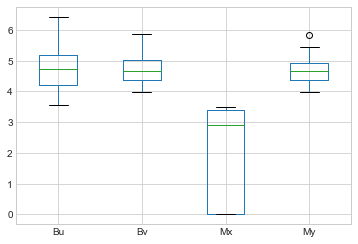

In [38]:
Knew_df.boxplot(column=['Bu', 'Bv', 'Mx', 'My'])
plt.show()

Since the ideal # of clusters for K-means is different than that of GMM, the K-means clustering technique does not exactly replicate GMM but it remains relatively similar.

In [66]:
#Task3
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
baseline_std = baseline_csv.drop(columns=['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength'])
metformin_std = metformin_csv.drop(columns=['Chr', 'GeneID', 'Start', 'Stop', 'CodingLength'])

baseline_std = baseline_std.transpose()
metformin_std = metformin_std.transpose()

mean_baseline_vec = np.mean(baseline_std, axis=0)
mean_metformin_vec = np.mean(metformin_std, axis=0)

cov_baseline = np.cov(baseline_std.T)
cov_metformin = np.cov(metformin_std.T)

baseline_eig_vals, baseline_eig_vecs = np.linalg.eig(cov_baseline)
metformin_eig_vals, metformin_eig_vecs = np.linalg.eig(cov_metformin)

baseline_eig_pairs = [(np.abs(baseline_eig_vals[i]), baseline_eig_vecs[:,i]) for i in range(len(baseline_eig_vals))]
baseline_eig_pairs.sort(key=lambda x: x[0], reverse=True)

for i in baseline_eig_pairs:
    print(i[0],": ",i[1])

metformin_eig_pairs = [(np.abs(metformin_eig_vals[i]), metformin_eig_vecs[:,i]) for i in range(len(metformin_eig_vals))]
metformin_eig_pairs.sort(key=lambda x: x[0], reverse=True)
for i in metformin_eig_pairs:
    print(i[0],": ",i[1])
    

[[ 6.40246859e+03 -2.64278731e+03 -6.57386980e+02 ... -2.58066406e+02
  -6.93769944e+03  1.61208112e+03]
 [-2.64278731e+03  7.11183211e+04  2.56108980e+03 ...  1.05739090e+04
   9.62003379e+03 -7.62117301e+03]
 [-6.57386980e+02  2.56108980e+03  5.99383770e+03 ...  2.92553115e+02
   8.12749393e+03 -1.87036026e+03]
 ...
 [-2.58066406e+02  1.05739090e+04  2.92553115e+02 ...  2.02017330e+04
   6.56070572e+03 -4.63559018e+03]
 [-6.93769944e+03  9.62003379e+03  8.12749393e+03 ...  6.56070572e+03
   5.04079489e+05  2.35889238e+04]
 [ 1.61208112e+03 -7.62117301e+03 -1.87036026e+03 ... -4.63559018e+03
   2.35889238e+04  1.58822634e+04]]
4255830263.15174 :  [-0.00025519+0.j  0.00104352+0.j  0.00024425+0.j ...  0.00041346+0.j
 -0.00038282+0.j -0.00144758+0.j]
54036144.520851746 :  [ 0.00218542+0.j  0.00031892+0.j -0.00295964+0.j ...  0.0027925 +0.j
 -0.01214673+0.j  0.00280927+0.j]
17201177.608385812 :  [-0.00375811+0.j -0.00384839+0.j  0.0011517 +0.j ... -0.00645662+0.j
  0.06745663+0.j  0.01405

26608.853164249216 :  [ 0.00295708+0.j -0.05725992+0.j  0.03175115+0.j ...  0.08508113+0.j
 -0.04064665+0.j -0.00264068+0.j]
25750.203861031765 :  [ 0.00406061+0.j -0.06306945+0.j  0.03827765+0.j ... -0.03084428+0.j
 -0.055439  +0.j  0.00196108+0.j]
25655.382314520044 :  [-0.01662843+0.j -0.06231714+0.j  0.02618954+0.j ...  0.01573581+0.j
  0.02530585+0.j  0.01532493+0.j]
24799.02369752576 :  [ 0.00941   +0.j -0.05881184+0.j  0.00814675+0.j ... -0.04182925+0.j
  0.04728519+0.j -0.01000575+0.j]
24599.2580106515 :  [-0.00810098+0.j -0.09521852+0.j -0.0008936 +0.j ...  0.02023892+0.j
 -0.03487042+0.j -0.01193364+0.j]
24215.973945494447 :  [-0.00913389+0.j -0.06704705+0.j  0.00384508+0.j ... -0.03290774+0.j
 -0.00293532+0.j  0.00174189+0.j]
23460.041831990948 :  [-0.00870631+0.j -0.03079457+0.j  0.06831729+0.j ... -0.01850535+0.j
  0.01190621+0.j  0.00024825+0.j]
23306.00420633345 :  [ 0.01140655+0.j -0.06777888+0.j -0.02006658+0.j ...  0.03869493+0.j
 -0.03239739+0.j -0.00425588+0.j]
2300

1.2035635525511497e-10 :  [ 2.04538873e-04+0.0006718 j  6.95154698e-05+0.00027987j
  7.02710709e-04+0.00026433j ... -7.32678600e-03-0.01640098j
 -5.50942184e-03-0.00829942j  4.71275002e-02+0.0369309 j]
1.2035635525511497e-10 :  [ 2.04538873e-04-0.0006718 j  6.95154698e-05-0.00027987j
  7.02710709e-04-0.00026433j ... -7.32678600e-03+0.01640098j
 -5.50942184e-03+0.00829942j  4.71275002e-02-0.0369309 j]
1.2010328546544094e-10 :  [ 0.00014961+0.j -0.00016033+0.j  0.00052951+0.j ... -0.00537154+0.j
 -0.00838423+0.j  0.00580282+0.j]
1.183274814143777e-10 :  [-6.04799194e-04+9.51006804e-05j  8.81573930e-05+1.67312115e-04j
  2.01688574e-04+1.28911496e-04j ... -1.58109340e-02-1.28337136e-02j
  1.07677085e-03-1.42924942e-03j  1.69149597e-02+2.63900784e-02j]
1.183274814143777e-10 :  [-6.04799194e-04-9.51006804e-05j  8.81573930e-05-1.67312115e-04j
  2.01688574e-04-1.28911496e-04j ... -1.58109340e-02+1.28337136e-02j
  1.07677085e-03+1.42924942e-03j  1.69149597e-02-2.63900784e-02j]
1.173617650395721

3.44115584494334e-11 :  [ 9.06536341e-05+3.06779108e-04j  4.93443474e-05+1.92899449e-05j
  1.07843404e-04+7.68614846e-05j ...  1.79106057e-02+3.72334308e-02j
  4.49520983e-03+5.89954091e-03j -1.20157657e-02+1.40868535e-02j]
3.44115584494334e-11 :  [ 9.06536341e-05-3.06779108e-04j  4.93443474e-05-1.92899449e-05j
  1.07843404e-04-7.68614846e-05j ...  1.79106057e-02-3.72334308e-02j
  4.49520983e-03-5.89954091e-03j -1.20157657e-02-1.40868535e-02j]
3.43897637109175e-11 :  [-1.05721477e-04+5.35124535e-05j -1.78867415e-05+2.27577096e-05j
 -1.08351721e-06-1.07153944e-04j ...  1.84481318e-02+1.13100386e-02j
  7.14097279e-03+1.20217421e-02j -3.29726769e-02+2.03330983e-03j]
3.43897637109175e-11 :  [-1.05721477e-04-5.35124535e-05j -1.78867415e-05-2.27577096e-05j
 -1.08351721e-06+1.07153944e-04j ...  1.84481318e-02-1.13100386e-02j
  7.14097279e-03-1.20217421e-02j -3.29726769e-02-2.03330983e-03j]
3.4168515032675856e-11 :  [-2.31595511e-05+3.50198792e-06j  6.19291010e-05-2.16441929e-05j
  3.81303510e

1.0938114017341134e-11 :  [-1.46092235e-04+0.j -1.47311149e-05+0.j  1.13302781e-04+0.j ...
  6.05655483e-02+0.j  1.18651941e-02+0.j -3.53568984e-02+0.j]
1.0789026540488174e-11 :  [ 9.50112736e-05-1.19680766e-04j -2.33889541e-05+6.71082193e-05j
 -6.64784733e-05-1.35196387e-04j ...  7.64703555e-03+2.18695738e-02j
 -5.91786425e-03+5.38600834e-03j -1.85963325e-02+3.96732074e-02j]
1.0789026540488174e-11 :  [ 9.50112736e-05+1.19680766e-04j -2.33889541e-05-6.71082193e-05j
 -6.64784733e-05+1.35196387e-04j ...  7.64703555e-03-2.18695738e-02j
 -5.91786425e-03-5.38600834e-03j -1.85963325e-02-3.96732074e-02j]
1.076312889234526e-11 :  [-2.27140170e-04-3.81789912e-05j  5.43501615e-05+2.84277462e-05j
  1.17124803e-05+4.52158578e-05j ... -2.01853848e-02+5.27363816e-03j
 -7.81645154e-04+1.03681773e-04j  5.12815622e-02-1.33710752e-02j]
1.076312889234526e-11 :  [-2.27140170e-04+3.81789912e-05j  5.43501615e-05-2.84277462e-05j
  1.17124803e-05-4.52158578e-05j ... -2.01853848e-02-5.27363816e-03j
 -7.8164515

 -0.00114471+0.j -0.0042589 +0.j]
51708.327453913385 :  [ 0.00852401+0.j  0.02183092+0.j  0.00178773+0.j ...  0.00795395+0.j
  0.0056111 +0.j -0.00194216+0.j]
50959.392237005595 :  [ 0.00151669+0.j  0.0940139 +0.j -0.01219381+0.j ...  0.00518427+0.j
 -0.01471602+0.j -0.00493864+0.j]
48364.25597415091 :  [-0.00397157+0.j -0.06938781+0.j  0.01449656+0.j ...  0.00156735+0.j
 -0.00465702+0.j -0.01359776+0.j]
47711.91100340025 :  [ 0.00184602+0.j -0.0361351 +0.j  0.00965031+0.j ...  0.00991225+0.j
 -0.02925064+0.j -0.0017673 +0.j]
47234.15199885137 :  [ 0.00946278+0.j -0.0222937 +0.j  0.00127858+0.j ...  0.00129212+0.j
 -0.0203306 +0.j -0.00510007+0.j]
47105.21376735359 :  [-0.00217496+0.j  0.10190882+0.j -0.01889922+0.j ...  0.00124736+0.j
 -0.00217754+0.j  0.00788147+0.j]
46768.31751474451 :  [-0.0023415 +0.j -0.11149444+0.j -0.00033593+0.j ... -0.01648151+0.j
  0.01684047+0.j  0.00987162+0.j]
45777.13593423612 :  [ 0.00031607+0.j  0.05927059+0.j -0.02052244+0.j ... -0.01027666+0.j
 -0.02

1.3038905200883116e-10 :  [ 4.43145518e-04+0.00039971j -6.17967246e-05-0.0001315 j
 -2.16952036e-04-0.00132171j ...  3.29648826e-02+0.02678173j
  5.66022807e-02+0.01133265j -9.07462089e-03-0.004143  j]
1.2875857685108255e-10 :  [ 1.67897478e-04+0.00053482j  4.29956715e-06+0.00013757j
  1.54928940e-03-0.00016008j ... -4.22459496e-02-0.04940788j
  1.72489407e-03-0.00556054j -1.71335190e-02-0.00918224j]
1.2875857685108255e-10 :  [ 1.67897478e-04-0.00053482j  4.29956715e-06-0.00013757j
  1.54928940e-03+0.00016008j ... -4.22459496e-02+0.04940788j
  1.72489407e-03+0.00556054j -1.71335190e-02+0.00918224j]
1.2728355923205099e-10 :  [-1.14524859e-03+0.j  7.73693957e-05+0.j -7.44912578e-04+0.j ...
  8.96180860e-03+0.j -3.61976378e-03+0.j  9.27913872e-03+0.j]
1.2636609851706024e-10 :  [ 6.60493614e-04+0.j  8.94712346e-05+0.j -8.40719885e-04+0.j ...
 -4.38530441e-02+0.j -6.47576354e-02+0.j  6.63441852e-03+0.j]
1.2034794217335022e-10 :  [ 0.00075012-0.00117552j -0.00024629-0.00016132j -0.00106259+0

2.0904739088677606e-11 :  [ 5.80989303e-04+1.81051777e-04j -9.92247372e-05-8.47328085e-06j
  3.28855454e-05-9.82988190e-05j ... -1.89021832e-02-5.20308788e-02j
  3.33575119e-03-3.07465955e-02j -1.01173339e-04+6.85581626e-04j]
2.0674211787741306e-11 :  [ 8.82418119e-05+0.j  1.47275830e-04+0.j  5.37062749e-05+0.j ...
 -5.33218217e-02+0.j -8.71319730e-03+0.j  1.91906070e-02+0.j]
2.0510539842544975e-11 :  [-2.06773015e-05+0.j -1.96250469e-05+0.j -9.60892332e-05+0.j ...
 -2.08533227e-02+0.j  4.42014864e-02+0.j  1.13396285e-02+0.j]
2.0370281719673506e-11 :  [ 7.07264780e-04+3.46357409e-05j -6.45585248e-06-6.76903867e-05j
  1.00773893e-04-8.19297825e-05j ...  2.42557995e-04+1.72773663e-02j
 -7.74310025e-03-6.01544417e-02j  4.52887821e-02+4.70218155e-03j]
2.0370281719673506e-11 :  [ 7.07264780e-04-3.46357409e-05j -6.45585248e-06+6.76903867e-05j
  1.00773893e-04+8.19297825e-05j ...  2.42557995e-04-1.72773663e-02j
 -7.74310025e-03+6.01544417e-02j  4.52887821e-02-4.70218155e-03j]
2.03324275067544

3.277171969228477e-12 :  [ 1.35413396e-05-2.60700537e-05j -4.57219672e-05-1.76999566e-05j
 -1.24863549e-04-4.70314397e-05j ... -3.15463584e-02-1.14690502e-02j
 -2.58823964e-02+1.84932120e-02j -1.42578776e-02+5.33956461e-02j]
2.9683611315719507e-12 :  [-8.32611731e-04+0.j -3.04838779e-05+0.j -9.76708472e-06+0.j ...
  2.13416345e-02+0.j -5.22308233e-02+0.j -4.34732179e-02+0.j]
2.903175779497031e-12 :  [-8.63296733e-06+8.54066626e-04j  4.81726294e-05-7.05736307e-06j
  8.96013404e-05-1.39911421e-04j ...  3.63126979e-02+2.58266722e-02j
  5.25857385e-02-1.05025097e-02j -3.31371331e-02-2.35208298e-02j]
2.903175779497031e-12 :  [-8.63296733e-06-8.54066626e-04j  4.81726294e-05+7.05736307e-06j
  8.96013404e-05+1.39911421e-04j ...  3.63126979e-02-2.58266722e-02j
  5.25857385e-02+1.05025097e-02j -3.31371331e-02+2.35208298e-02j]
2.7913210219074803e-12 :  [ 1.92556140e-04-1.78592711e-04j  3.26986070e-05-1.18446913e-05j
  3.97110757e-05-7.99133257e-05j ...  1.42083882e-02-1.59518818e-02j
 -5.66240383

In [40]:
total = sum(baseline_eig_vals)
baseline_var_exp = [(i / total)*100 for i in sorted(baseline_eig_vals, reverse=True)]
baseline_cum_var_exp = np.cumsum(baseline_var_exp)
print(baseline_cum_var_exp)

total = sum(metformin_eig_vals)
metformin_var_exp = [(i / total)*100 for i in sorted(metformin_eig_vals, reverse=True)]
metformin_cum_var_exp = np.cumsum(metformin_var_exp)
print(metformin_cum_var_exp)

[ 96.30770128+0.00000000e+00j  97.53051717+0.00000000e+00j
  97.9197728 +0.00000000e+00j ... 100.        +2.27327242e-17j
 100.        +0.00000000e+00j 100.        +0.00000000e+00j]
[ 96.5753673 +0.0000000e+00j  97.34256751+0.0000000e+00j
  98.02445192+0.0000000e+00j ... 100.        +1.1967404e-17j
 100.        +0.0000000e+00j 100.        +0.0000000e+00j]


In [41]:
baseline_matrix_w = np.hstack((baseline_eig_pairs[0][1].reshape(1170,1),
                      baseline_eig_pairs[1][1].reshape(1170,1)))
#print(baseline_matrix_w)

baseline_Y = baseline_std.dot(baseline_matrix_w)
print(baseline_Y)

metformin_matrix_w = np.hstack((metformin_eig_pairs[0][1].reshape(1170,1),
                      metformin_eig_pairs[1][1].reshape(1170,1)))
#print(metformin_matrix_w)

metformin_Y = metformin_std.dot(metformin_matrix_w)
print(metformin_Y)

                                               0                         1
s_62_M2_N701_S502_RPKM  (-2066.7416104595304+0j)   (-378.7197803070644+0j)
s_62_M2_N701_S503_RPKM   (-159010.9620727781+0j)  (-29191.937282943487+0j)
s_62_M2_N701_S504_RPKM  (-1163.2644999903316+0j)   (-435.3529870326178+0j)
s_62_M2_N701_S505_RPKM  (-1379.4548688217571+0j)  (-1229.9426632515901+0j)
s_62_M2_N701_S506_RPKM  (-1853.3128546067528+0j)  (-1355.8204149528674+0j)
s_62_M2_N701_S507_RPKM  (-1757.2207332832054+0j)     (655.723966230525+0j)
s_62_M2_N701_S508_RPKM  (-1201.2893422029097+0j)     (-8.0578527267759+0j)
s_62_M2_N702_S501_RPKM    (-2173.34504077277+0j)  (-381.93867466039376+0j)
s_62_M2_N702_S502_RPKM  (-2014.3857387122343+0j)    (167.7904498434412+0j)
s_62_M2_N702_S503_RPKM  (-1546.6416909778602+0j)   (-195.8312649886709+0j)
s_62_M2_N702_S504_RPKM  (-1338.9992457245885+0j)  (-156.40167670935327+0j)
s_62_M2_N702_S505_RPKM  (-1815.0152110048514+0j)   (-574.0329570240149+0j)
s_62_M2_N702_S506_RPKM  (

In [42]:
from sklearn.decomposition import PCA as sklearnPCA
baseline_sklearn_pca = sklearnPCA(n_components=2)
baselineY_sklearn = baseline_sklearn_pca.fit_transform(baseline_std)

# 0,1 denote PC1 and PC2; change values for other PCs
baseline_xvector = baseline_sklearn_pca.components_[0] 
baseline_yvector = baseline_sklearn_pca.components_[1]

baseline_xs = baseline_sklearn_pca.transform(baseline_std)[:,0] 
baseline_ys = baseline_sklearn_pca.transform(baseline_std)[:,1]

metformin_sklearn_pca = sklearnPCA(n_components=2)
metforminY_sklearn = metformin_sklearn_pca.fit_transform(metformin_std)

# 0,1 denote PC1 and PC2; change values for other PCs
metformin_xvector = metformin_sklearn_pca.components_[0] 
metformin_yvector = metformin_sklearn_pca.components_[1]

metformin_xs = metformin_sklearn_pca.transform(metformin_std)[:,0] 
metformin_ys = metformin_sklearn_pca.transform(metformin_std)[:,1]

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


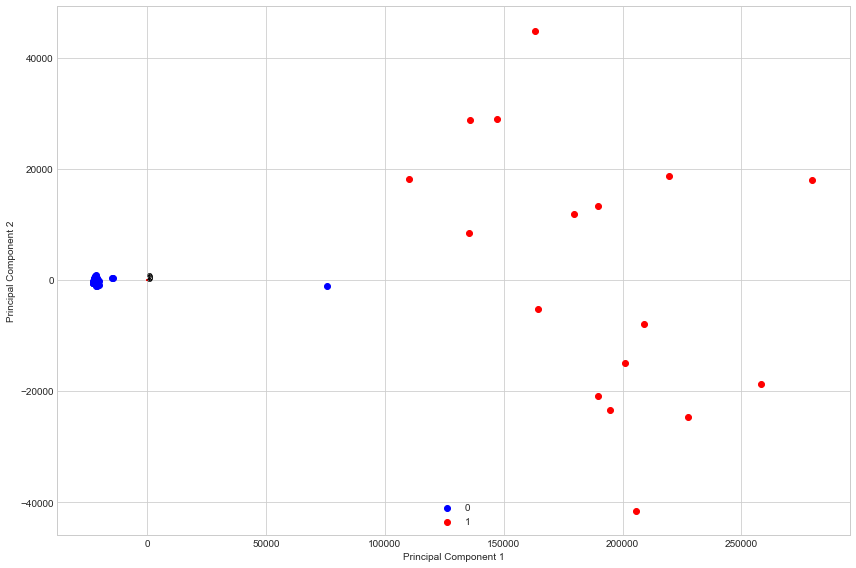

In [45]:
baseline_numpY = baseline_Y.as_matrix()
print(baseGMM_pred)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 8))
    for lab, col in zip((0, 1),
                        ('blue', 'red')):
        plt.scatter(baselineY_sklearn[baseGMM_pred == lab, 0],
                    baselineY_sklearn[baseGMM_pred == lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    
    for i in range(len()):
# arrows project features (ie columns from csv) as vectors onto PC axes
        plt.arrow(0, 0, baseline_xvector[i]*max(baseline_xs), baseline_yvector[i]*max(baseline_ys),
              color='r', width=0.0005, head_width=0.0025)
    
        plt.text(baseline_xvector[i]*max(baseline_xs)*1.2, baseline_yvector[i]*max(baseline_ys)*1.2,
             list(baseline_std.columns.values)[i], color='black')
    
    plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 2 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


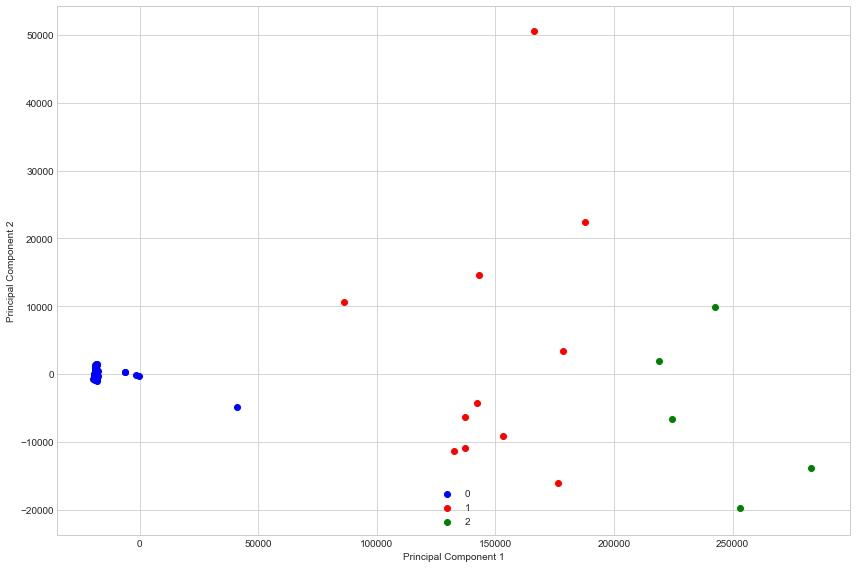

In [44]:
metformin_numpY = metformin_Y.as_matrix()
print(metGMM_pred)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 8))
    for lab, col in zip((0, 1, 2),
                        ('blue', 'red', 'green')):
        plt.scatter(metforminY_sklearn[metGMM_pred == lab, 0],
                    metforminY_sklearn[metGMM_pred == lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()